In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

In [30]:
df = pd.read_csv("Data/concept2-season-2020.csv")

In [73]:
col_to_drop = ["Stroke Count","Avg Heart Rate","Comments","Weight","Type","Ranked"]
clean_df = df.drop(col_to_drop, axis='columns')
clean_df['Date'] = pd.to_datetime(clean_df['Date'])
clean_df['Pace'] = pd.to_datetime(clean_df['Pace'],format='%M:%S.%f')
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID                     105 non-null    int64         
 1   Date                   105 non-null    datetime64[ns]
 2   Description            105 non-null    object        
 3   Work Time (Formatted)  105 non-null    object        
 4   Work Time (Seconds)    105 non-null    float64       
 5   Rest Time (Formatted)  21 non-null     object        
 6   Rest Time (Seconds)    21 non-null     float64       
 7   Work Distance          105 non-null    int64         
 8   Rest Distance          21 non-null     float64       
 9   Stroke Rate/Cadence    105 non-null    int64         
 10  Pace                   105 non-null    datetime64[ns]
 11  Avg Watts              105 non-null    int64         
 12  Cal/Hour               105 non-null    int64         
 13  Total

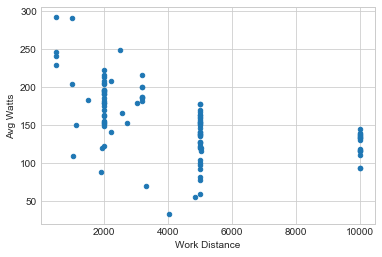

In [82]:
clean_df.plot(x="Work Distance",y="Avg Watts",kind="scatter")
y_avg = np.average(clean_df["Avg Watts"])
plt.show()